In [1]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import geopandas as gpd

In [24]:
noised_isd = pd.read_csv("irving_blocks/noised_isd.csv")
noised_city = pd.read_csv("irving_blocks/noised_city.csv")

In [118]:
noised_isd_pct = noised_isd.groupby(["PCT08_NM", 
                                     "epsilon", 
                                     "split"]).sum()[["HVAP10", "VAP10", 'IR06ISD3ST', 'IR06ISD3BE', 
                                                      'IR06ISD4JO', 'IR06ISD4CA', 'IR08ISD1PO', 
                                                      'IR08ISD1BA', 'IR08ISD1JO', 'IR08ISD2JE',
                                                      'IR08ISD2CH', 'CVAP09', 'HCVAP09','CVAP00', 'HCVAP00'] 
                                     + [col for col in noised_isd.columns if 'noise' in col]].reset_index()
noised_city_pct = noised_city.groupby(["PCT08_NM", 
                                       "epsilon", 
                                       "split"]).sum()[['IR05CC5CAN','IR05CC5MED', 'IR05CC5COL', 
                                                        'IR08MAYGEA', 'IR08MAYJET', 'IR08MAYREZ',
                                                        'IR08CC3MEA', 'IR08CC3RIV',"HVAP10", "VAP10", 
                                                        'CVAP09', 'HCVAP09', 'CVAP00', 'HCVAP00']
                                       + [col for col in noised_city.columns if 'noise' in col]].reset_index()

In [141]:
def plot_er_graph(data, cand, elect, cand_col, elect_cols, eps, split,
                  filt=True, n_samps=32, ax=None, title=True, plot_cvap=False):
    
    df = data.query("epsilon == @eps & split == @split")
    df = df.query(" | ".join(["{} != 0".format(c) for c in elect_cols])) if filt else df
    xp = np.linspace(0, 1, 100)
    perc_hvap = (df.HVAP10 / df.VAP10).fillna(0)
    perc_cand = (df[cand_col] / sum([df[c] for c in elect_cols])).fillna(0)
    line = sp.stats.linregress(perc_hvap, perc_cand)
    l = np.poly1d([line.slope, line.intercept])

    ms = np.zeros(n_samps)
    rs = np.zeros(n_samps)

    if ax==None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(1, 1, 1)
    if title: ax.set_title("ER - Votes for {}: {}".format(cand, elect))
    ax.set_xlim(-0.05,1.05)
    ax.set_ylim(-0.05,1.05)

    for i in range(n_samps):
        perc_hvap_noised = (df["{}_HVAP_noise".format(i)] / df["{}_VAP_noise".format(i)]).fillna(0)
            
        line_noised = sp.stats.linregress(perc_hvap_noised, perc_cand)
        ln = np.poly1d([line_noised.slope, line_noised.intercept])
        ms[i] = line_noised.slope
        rs[i] = line_noised.rvalue
        ax.plot(perc_hvap_noised, perc_cand, '.', color="lightcoral")
        ax.plot(xp, ln(xp), '-', color="lightcoral")
        
    if plot_cvap:
        perc_hcvap = (df.HCVAP09 / df.CVAP09).fillna(0)
        line_cvap = sp.stats.linregress(perc_hcvap, perc_cand)
        l_cvap = np.poly1d([line_cvap.slope, line_cvap.intercept])
        ax.plot(perc_hcvap, perc_cand, '.', color="grey")
        ax.plot(xp, l_cvap(xp), linestyle="dashed", color="grey", 
                label="HCVAP09 | m: {}, R^2: {}".format(round(line_cvap.slope, 3), 
                                                        round(line_cvap.rvalue**2,3)))
        
        perc_hcvap = (df.HCVAP00 / df.CVAP00).fillna(0)
        line_cvap = sp.stats.linregress(perc_hcvap, perc_cand)
        l_cvap = np.poly1d([line_cvap.slope, line_cvap.intercept])
        ax.plot(perc_hcvap, perc_cand, '.', color="k")
        ax.plot(xp, l_cvap(xp), linestyle="dashed", color="k", 
                label="HCVAP00 | m: {}, R^2: {}".format(round(line_cvap.slope, 3), 
                                                        round(line_cvap.rvalue**2,3)))
    
    ax.plot(perc_hvap, perc_cand, '.', color="b")
    ax.plot(xp, l(xp), '-', color="b", 
             label="m: {}, R^2: {}".format(round(line.slope, 3), round(line.rvalue**2,3)))
    ax.plot([], [], '-', color="r", 
             label="E(m): {}, E(R^2): {}".format(round(np.mean(ms),3), round(np.mean(rs**2),3)))  
    
    ax.legend()
    ax.set_xlabel("% HVAP")
    ax.set_ylabel("{} % of Voters".format(cand))
    return ax

In [145]:
def plot_elect_grid(epsilon_values, epsilon_splits, data, candidate, election, 
                    candidate_col, election_cols, figsize=(10,10)):
    
    fig, axs = plt.subplots(len(epsilon_values),len(epsilon_splits), figsize=figsize)

    fig.suptitle("ER - Votes for {}: {}".format(candidate, election))
    plt.subplots_adjust(hspace = 0.25)

    for i in range(len(epsilon_values)):
        for j in range(len(epsilon_splits)):
            plot_er_graph(data, candidate, election, candidate_col, election_cols, 
                          epsilon_values[i], epsilon_splits[j], title=False, ax=axs[i,j])

    pad = 5
    for ax, row in zip(axs[:,0], ["$\epsilon$ = {}".format(eps) for eps in epsilon_values]):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')

    for ax, col in zip(axs[0], ["Split: {}".format(s) for s in epsilon_splits]):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, ax.xaxis.labelpad + pad),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline')
        
    return fig, axs

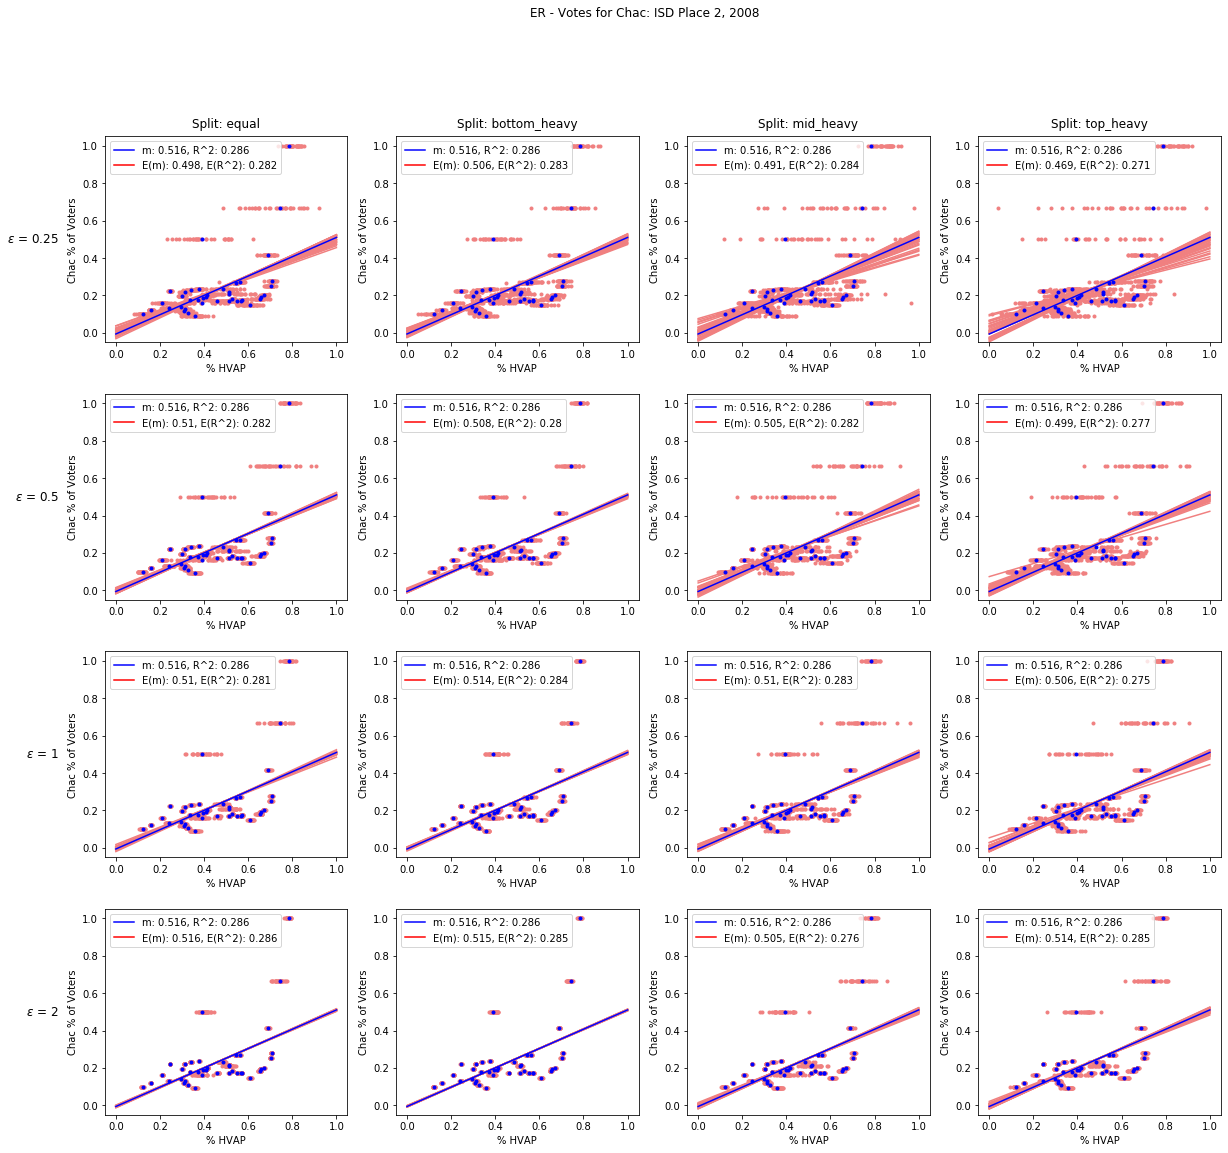

In [163]:
epsilon_values = [0.25, 0.5, 1, 2]
epsilon_splits = ["equal","bottom_heavy", "mid_heavy", "top_heavy",]
data = noised_isd_pct
candidate = "Chac"
election = "ISD Place 2, 2008"
candidate_col = "IR08ISD2CH"
election_cols = ["IR08ISD2CH", "IR08ISD2JE"]

fig, axs = plot_elect_grid(epsilon_values, epsilon_splits, data, candidate, election, 
                           candidate_col, election_cols, figsize=(20,18))
plt.savefig("plots/ER_{}_{}_elect_param_grid.png".format(candidate, election.replace(',', "").replace(' ', '_')),
            dpi=200)

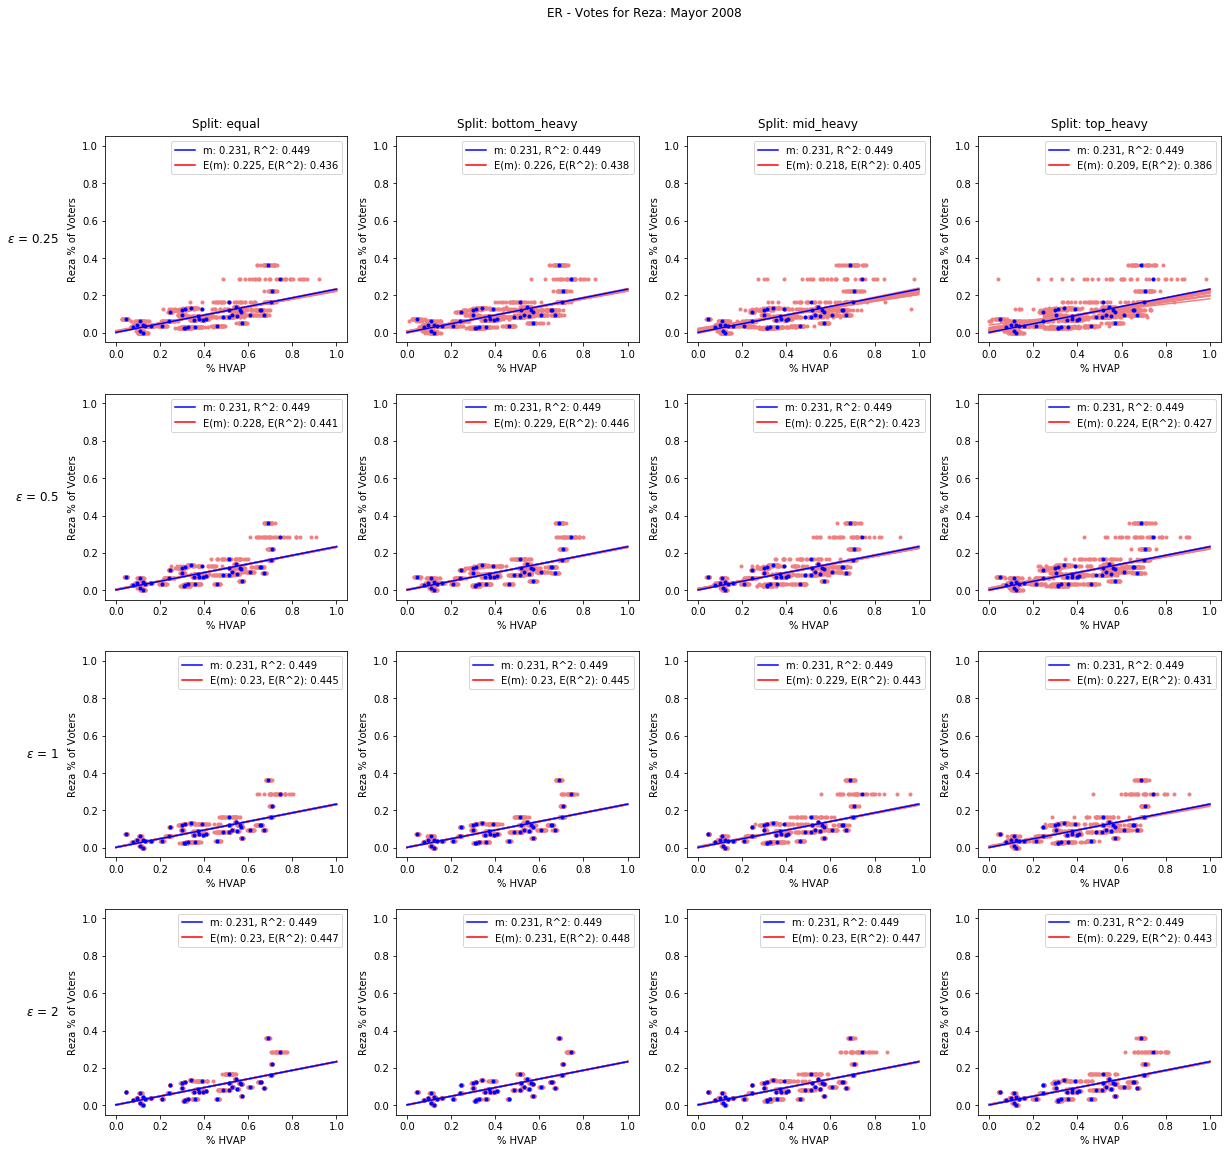

In [164]:
epsilon_values = [0.25, 0.5, 1, 2]
epsilon_splits = ["equal","bottom_heavy", "mid_heavy", "top_heavy",]
data = noised_city_pct
candidate = "Reza"
election = "Mayor 2008"
candidate_col = "IR08MAYREZ"
election_cols = ["IR08MAYREZ", "IR08MAYGEA", "IR08MAYJET"]

fig, axs = plot_elect_grid(epsilon_values, epsilon_splits, data, candidate, election, 
                           candidate_col, election_cols, figsize=(20,18))
plt.savefig("plots/ER_{}_{}_elect_param_grid.png".format(candidate, election.replace(',', "").replace(' ', '_')),
            dpi=200)

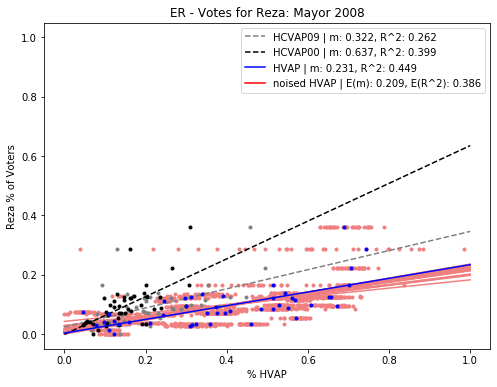

In [139]:
fig = plot_er_graph(noised_city_pct, "Reza", "Mayor 2008", "IR08MAYREZ", 
                    ["IR08MAYREZ", "IR08MAYGEA", "IR08MAYJET"], 0.25, "top_heavy", plot_cvap=True)
plt.savefig("plots/ER_Reza_Mayor_2008_display_cvap.png")

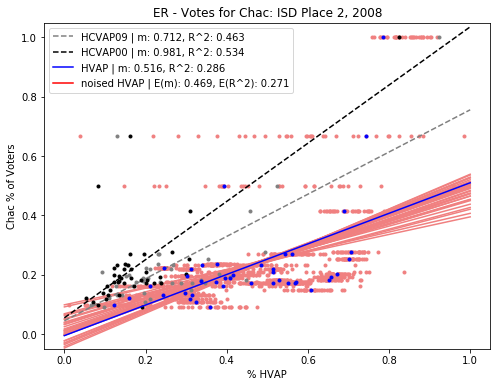

In [140]:
fig = plot_er_graph(noised_isd_pct, "Chac", "ISD Place 2, 2008", "IR08ISD2CH", 
                    ["IR08ISD2CH", "IR08ISD2JE"], 0.25, "top_heavy", plot_cvap=True)
plt.savefig("plots/ER_Chac_ISD_Pl2_2008_display_cvap.png")